In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
from openpyxl import Workbook
from pandas import ExcelWriter

In [2]:
data = pd.read_excel('dataset.xlsx', sheet_name='Данные')
clients = pd.read_excel('dataset.xlsx', sheet_name='Clients')
region_dict = pd.read_excel('dataset.xlsx', sheet_name='Region_dict')


### Приводим dtime_pay к типу дата

In [3]:
data['dtime_pay'] = data['dtime_pay'].astype(str)
data['dtime_pay'] = pd.to_datetime(data['dtime_pay'])

### Убираем нуловые значения, как некорректные данные, попавшие в выборку

In [4]:
data.isnull().sum()

id_order          0
id_client       588
amt_payment    2144
dtime_pay      2161
dtype: int64

In [5]:
data = data[~data['dtime_pay'].isnull()]

In [6]:
clients.isnull().sum()

id_client             0
dtime_ad            249
nflag_test            0
id_trading_point      0
dtype: int64

In [7]:
clients = clients[~clients['dtime_ad'].isnull()]

### Создаем сгруппированную таблицу, поскольку есть клиенты с несколькими платежами

In [8]:
data = data.groupby('id_client').agg({'id_order':'min','amt_payment':'sum','dtime_pay':'min'}).reset_index()

### Объединяем все таблицы с данными

In [9]:
df_m = clients.merge(data, on = 'id_client', how = 'left' )

In [10]:
df_m = df_m.merge(region_dict, on = 'id_trading_point')

### Добавляем флаг платежа, который принимает значения 0 или 1 в зависимости от того, заплатил клиент или нет

In [11]:
df_m['nflag_purchase'] = np.where(df_m['amt_payment'] > 0, 1, 0)

### Заменяем нуловые платежи на 0

In [12]:
df_m['amt_payment'].fillna(0, inplace=True)

### В начальных таблицах колонки amt_payment, id_order имеют тип данных float. Проверяем что у всех значений после запятой находится 0 и приводим их к int.

In [13]:
df_m.dtypes

id_client                    int64
dtime_ad            datetime64[ns]
nflag_test                   int64
id_trading_point             int64
id_order                   float64
amt_payment                float64
dtime_pay           datetime64[ns]
city                        object
nflag_purchase               int32
dtype: object

In [14]:
# Проверка условия для каждого значения в колонке
result_amt_payment = df_m['amt_payment'].apply(lambda x: x % 1 == 0)
result_id_order = df_m['id_order'][~df_m['id_order'].isnull()].apply(lambda x: x % 1 == 0)
# Если все значения удовлетворяют условию (после точки идет 0), result будет True для всех строк
print(result_amt_payment.all())
print(result_id_order.all())
df_m['amt_payment'] = df_m['amt_payment'].astype(int)
df_m['id_order'] = df_m['id_order'].astype('Int64')

True
True


In [15]:
df_m.dtypes

id_client                    int64
dtime_ad            datetime64[ns]
nflag_test                   int64
id_trading_point             int64
id_order                     Int64
amt_payment                  int32
dtime_pay           datetime64[ns]
city                        object
nflag_purchase               int32
dtype: object

In [16]:
df_m

,id_client,dtime_ad,nflag_test,id_trading_point,id_order,amt_payment,dtime_pay,city,nflag_purchase
0,180844,2022-06-08 18:38:41.414,0,212,157381,5349,2022-10-12 00:47:53.057,Красноярск,1
1,223863,2022-08-20 21:56:54.325,0,212,<NA>,0,NaT,Красноярск,0
2,201715,2022-07-30 19:07:49.264,1,212,244320,4171,2022-11-17 05:05:30.194,Красноярск,1
3,292010,2022-07-26 20:37:16.885,1,212,<NA>,0,NaT,Красноярск,0
4,190438,2022-07-02 12:53:04.753,1,212,143826,6026,2022-09-25 20:03:33.341,Красноярск,1
...,...,...,...,...,...,...,...,...,...
55351,321313,2022-06-17 15:42:47.009,1,1002,<NA>,0,NaT,Москва,0
55352,200856,2022-07-28 14:51:08.149,1,1002,128424,6696,2022-10-24 18:19:39.643,Москва,1
55353,198305,2022-07-22 06:24:33.232,0,1002,246589,3901,2022-08-29 02:53:01.451,Москва,1
55354,201820,2022-07-31 01:25:03.638,0,1002,<NA>,0,NaT,Москва,0


### Группируем по городам

In [17]:
df_cities = df_m.groupby('city').agg(cnt_points = ('id_trading_point', 'nunique'),
                                             cnt = ('id_trading_point', 'count')
                                            ,amt_payment_sum = ('amt_payment', 'sum')
                                     ,nflag_test_1_cnt = ('nflag_test', 'sum')).reset_index()
df_cities.sort_values(by = 'cnt', ascending = False, inplace = True)
df_cities['nflag_test_0_cnt'] = df_cities['cnt'] - df_cities['nflag_test_1_cnt']

In [18]:
df_cities

,city,cnt_points,cnt,amt_payment_sum,nflag_test_1_cnt,nflag_test_0_cnt
7,Москва,11,12358,26887049,6134,6224
15,Санкт-Петербург,11,8879,19274790,4445,4434
6,Красноярск,5,5937,14446130,3037,2900
10,Новосибирск,6,5188,13310974,2042,3146
4,Казань,6,5077,13557527,2500,2577
5,Краснодар,4,4747,12370820,1024,3723
16,Саратов,2,2122,5380348,1013,1109
8,Мурманск,2,2120,3945800,1055,1065
14,Самара,4,1648,4070538,802,846
18,Сочи,2,1602,3869045,796,806


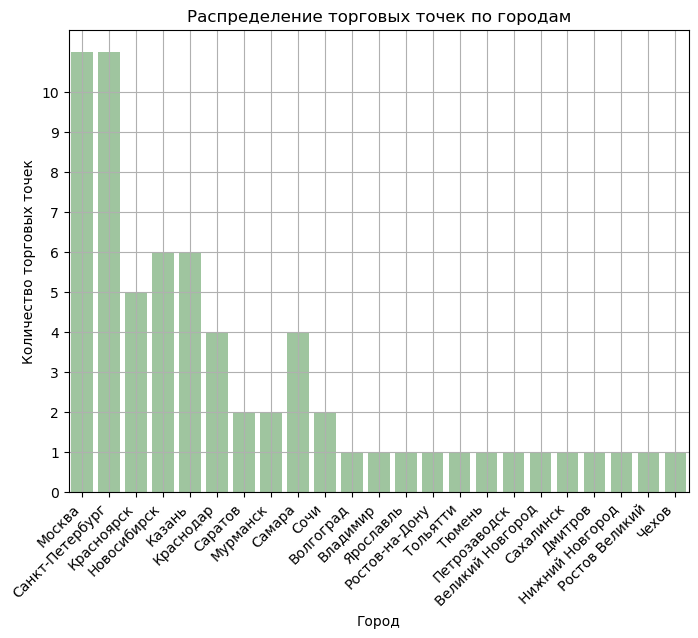

In [19]:
plt.figure(figsize=(8, 6))
sns.barplot(x=df_cities['city'], y=df_cities['cnt_points'], alpha =.4, color = 'green')
plt.title('Распределение торговых точек по городам')
plt.xlabel('Город')
plt.ylabel('Количество торговых точек')
plt.yticks(range(0, max(df_cities['cnt_points']), 1))
plt.xticks(rotation=45, ha='right')
plt.grid()
plt.show()

### Группируем по торговым точкам

In [20]:
df_trading_points = df_m.groupby('id_trading_point').agg(cnt = ('id_trading_point', 'count')
                                            ,amt_payment_sum = ('amt_payment', 'sum')
                                            ,nflag_test_1_cnt = ('nflag_test', 'sum')).reset_index()
df_trading_points.sort_values(by = 'cnt', ascending = False, inplace = True)
df_trading_points['nflag_test_0_cnt'] = df_trading_points['cnt'] - df_trading_points['nflag_test_1_cnt']
df_trading_points

,id_trading_point,cnt,amt_payment_sum,nflag_test_1_cnt,nflag_test_0_cnt
59,2652,4643,10373189,2273,2370
35,453,2115,4649626,1066,1049
20,80,1724,4335163,844,880
54,1101,1654,3901153,785,869
61,3987,1586,2571287,801,785
...,...,...,...,...,...
17,69,153,134671,75,78
1,2,149,79513,78,71
5,13,148,0,78,70
3,7,147,0,76,71


### Находим торговые точки, в которых не было заплачено ни одного рубля ни одним клиентом, или в которых пустует контрольная или тестовая группа. Исключаем их из выборки.

In [21]:
trading_points_zero_pay = []
trading_points_empty_group = []
for i, j in df_trading_points.iterrows():
    if j['amt_payment_sum'] == 0:
        trading_points_zero_pay.append(j['id_trading_point'])
    elif (j['nflag_test_1_cnt'] == 0) | (j['nflag_test_0_cnt'] == 0):
        trading_points_empty_group.append(j['id_trading_point'])       
print(trading_points_zero_pay)
print(trading_points_empty_group)
df_clean = df_m[~df_m['id_trading_point'].isin(trading_points_zero_pay + trading_points_empty_group)]

[26, 1, 23, 13, 7, 4]
[1099, 866, 1015, 800, 228, 810, 603, 739]


### Создаём функцию для группировки, чтобы посмотреть общие результаты АБ теста и сегментированные.

In [22]:
def group_function(df, group_list,
                   id_client_column = 'id_client', id_order_column = 'id_order', amt_pay_column = 'amt_payment'):
    df_gr = df.groupby(group_list).agg(count = (id_client_column, 'count'),
                                       order_count = (id_order_column, 'count'),
                                       avg_pay =(amt_pay_column, 'mean')).reset_index()
    df_gr['conv'] = df_gr['order_count'] / df_gr['count']
    df_gr.sort_values(by = group_list, inplace = True)
    return df_gr  

In [23]:
list1 = [ 'nflag_test']
df_gr_all = group_function(df_clean, list1)
df_gr_all

,nflag_test,count,order_count,avg_pay,conv
0,0,23402,11724,2193.027305,0.500983
1,1,23002,12194,2392.894748,0.530128


In [24]:
list2 = [ 'city', 'nflag_test']
df_gr_city = group_function(df_clean, list2)
df_gr_city

,city,nflag_test,count,order_count,avg_pay,conv
0,Владимир,0,608,303,2108.610197,0.498355
1,Владимир,1,509,280,2547.220039,0.550098
2,Волгоград,0,703,419,2601.761024,0.596017
3,Волгоград,1,657,363,2288.870624,0.552511
4,Дмитров,0,71,7,483.450704,0.098592
5,Дмитров,1,78,9,579.333333,0.115385
6,Казань,0,2577,1224,2610.688397,0.474971
7,Казань,1,2500,1197,2731.913200,0.478800
8,Краснодар,0,1139,744,2912.431080,0.653205
9,Краснодар,1,1024,629,2696.804688,0.614258


### Создаём функцию для расчёта статистических критериев как по всей выборке, так и сегментированно по городам.

In [25]:
def ttest_mw_func(df, city = 0, city_column ='city'
                 , flag_column_name = 'nflag_purchase', group_column = 'nflag_test', payment_column = 'amt_payment', alpha = .05
                 ):
    tt_list = []
    
    if city == 0:
        
        sns.displot(df[df[payment_column] > 0], x = payment_column, hue = group_column , height=6, aspect=1.5)
        plt.title('Гистограмма платежей')
        plt.xlabel('Сумма платежа')
        plt.ylabel('Количество')
        plt.show()
        
        tt_dict = {}
        s_t_con, p_t_conv = stat.ttest_ind(df[flag_column_name][df[group_column]==0], df[flag_column_name][df[group_column]==1])
        s_t_avg, p_t_avg = stat.ttest_ind(df[payment_column][df[group_column]==0], df[payment_column][df[group_column]==1])                           
        s_u, p_u = stat.mannwhitneyu(x=df[payment_column][df[group_column]==0], y=df[payment_column][df[group_column]==1])

        tt_dict['T-критерий сравнения конверсий'] = s_t_con
        tt_dict['P-value сравнения конверсий'] = p_t_conv
        
        if p_t_conv > alpha:
            tt_dict['Конверсии равны'] = True
        else:
            tt_dict['Конверсии равны'] = False
        
        tt_dict['Т-критерий сравнения средних'] = s_t_avg
        tt_dict['Р-value сравнений средних'] = p_t_avg
        
        
        if p_t_avg > alpha:
            tt_dict['Средние равны'] = True
        else:
            tt_dict['Средние равны'] = False
        
        
        tt_dict['U-критерий сравнения средних'] = s_u
        tt_dict['P-value U теста'] = p_u
        
        
        if p_u > alpha:
            tt_dict['Распределения равны'] = True
        else:
            tt_dict['Распределения равны'] = False
        
        
        tt_list.append(tt_dict)
    else:
        desired_values = ['Москва', 'Санкт-Петербург']
        
        for i in desired_values:
            
            sns.displot(df[(df[payment_column] > 0) & (df[city_column] == i)], x = payment_column, hue = group_column , height=6, aspect=1.5)
            plt.title(i)
            plt.xlabel('Сумма платежа')
            plt.ylabel('Количество')
            plt.show()
            
            tt_dict = {}
            s_t_con, p_t_conv = stat.ttest_ind(df[flag_column_name][(df[group_column]==0)&(df[city_column]==i)], df[flag_column_name][(df[group_column]==1)&(df[city_column]==i)])
            s_t_avg, p_t_avg = stat.ttest_ind(df[payment_column][(df[group_column]==0)&(df[city_column]==i)], df[payment_column][(df[group_column]==1)&(df[city_column]==i)])                           
            s_u, p_u = stat.mannwhitneyu(x=df[payment_column][(df[group_column]==0)&(df[city_column]==i)], y=df[payment_column][(df[group_column]==1)&(df[city_column]==i)])

            tt_dict['city'] = i
            tt_dict['T-критерий сравнения конверсий'] = s_t_con
            tt_dict['P-value сравнения конверсий'] = p_t_conv
            
            if p_t_conv > alpha:
                tt_dict['Конверсии равны'] = True
            else:
                tt_dict['Конверсии равны'] = False
            
            
            tt_dict['Т-критерий сравнения средних'] = s_t_avg
            tt_dict['Р-value сравнений средних'] = p_t_avg
            
            if p_t_avg > alpha:
                tt_dict['Средние равны'] = True
            else:
                tt_dict['Средние равны'] = False
            
            
            tt_dict['U-критерий сравнения средних'] = s_u
            tt_dict['P-value U теста'] = p_u
            
            if p_u > alpha:
                tt_dict['Распределения равны'] = True
            else:
                tt_dict['Распределения равны'] = False
            
            
            tt_list.append(tt_dict)
            
            
            for j,k in tt_dict.items():
                print(j,k)
            print()
        
        
        
        for i in df[city_column].unique():
            
            if i not in desired_values:
            
            
                        
                sns.displot(df[(df[payment_column] > 0) & (df[city_column] == i)], x = payment_column, hue = group_column , height=6, aspect=1.5)
                plt.title(i)
                plt.xlabel('Сумма платежа')
                plt.ylabel('Количество')
                plt.show()

                tt_dict = {}
                s_t_con, p_t_conv = stat.ttest_ind(df[flag_column_name][(df[group_column]==0)&(df[city_column]==i)], df[flag_column_name][(df[group_column]==1)&(df[city_column]==i)])
                s_t_avg, p_t_avg = stat.ttest_ind(df[payment_column][(df[group_column]==0)&(df[city_column]==i)], df[payment_column][(df[group_column]==1)&(df[city_column]==i)])                           
                s_u, p_u = stat.mannwhitneyu(x=df[payment_column][(df[group_column]==0)&(df[city_column]==i)], y=df[payment_column][(df[group_column]==1)&(df[city_column]==i)])

                tt_dict['city'] = i
                tt_dict['T-критерий сравнения конверсий'] = s_t_con
                tt_dict['P-value сравнения конверсий'] = p_t_conv

                if p_t_conv > alpha:
                    tt_dict['Конверсии равны'] = True
                else:
                    tt_dict['Конверсии равны'] = False


                tt_dict['Т-критерий сравнения средних'] = s_t_avg
                tt_dict['Р-value сравнений средних'] = p_t_avg

                if p_t_avg > alpha:
                    tt_dict['Средние равны'] = True
                else:
                    tt_dict['Средние равны'] = False


                tt_dict['U-критерий сравнения средних'] = s_u
                tt_dict['P-value U теста'] = p_u

                if p_u > alpha:
                    tt_dict['Распределения равны'] = True
                else:
                    tt_dict['Распределения равны'] = False


                tt_list.append(tt_dict)


                for j,k in tt_dict.items():
                    print(j,k)
                print()
            
            
    df_ret = pd.DataFrame(tt_list)
    numeric_columns = df_ret.select_dtypes(include=['number']).columns
    df_ret[numeric_columns] = df_ret[numeric_columns].applymap(lambda x: '{:.3f}'.format(x))
    return df_ret.style.hide(axis = 'index').highlight_min(subset = ['Конверсии равны', 'Средние равны', 'Распределения равны' ])


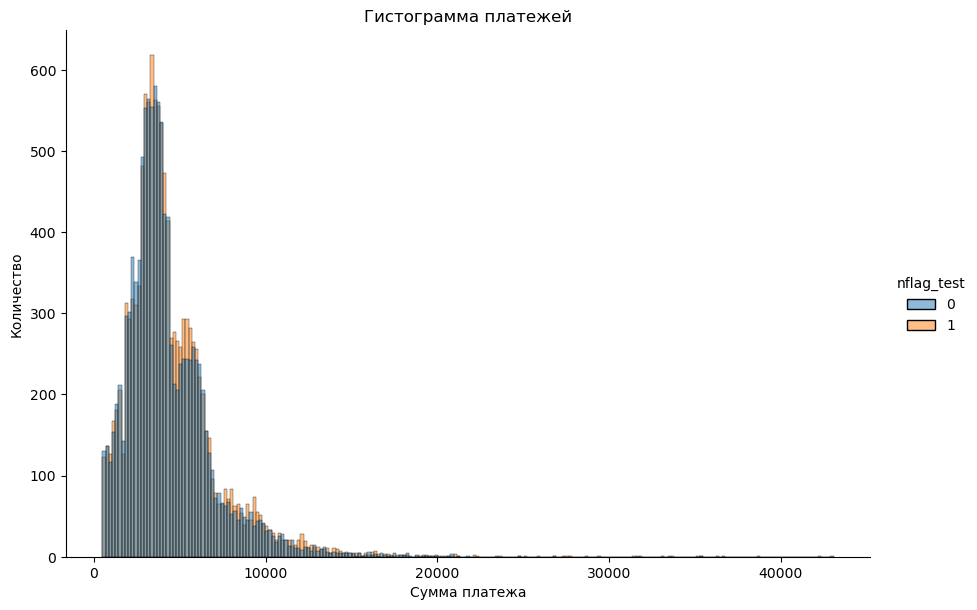

T-критерий сравнения конверсий,P-value сравнения конверсий,Конверсии равны,Т-критерий сравнения средних,Р-value сравнений средних,Средние равны,U-критерий сравнения средних,P-value U теста,Распределения равны
-6.284,0.000,False,-7.290,0.000,False,259061574.500,0.000,False


In [26]:
df_ab_all = ttest_mw_func(df_clean)
df_ab_all

## Если смотреть по всей выборке результат АБ теста успешен по всем таргет метрикам.

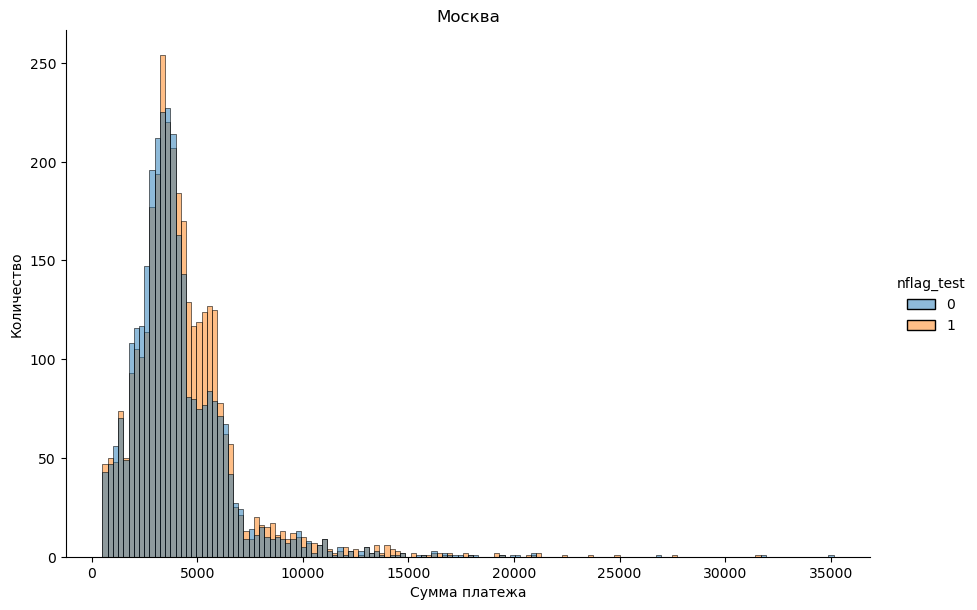

city Москва
T-критерий сравнения конверсий -6.190312288026297
P-value сравнения конверсий 6.194689260032549e-10
Конверсии равны False
Т-критерий сравнения средних -7.676511027843395
Р-value сравнений средних 1.757549439555765e-14
Средние равны False
U-критерий сравнения средних 17582441.5
P-value U теста 7.010591402203484e-16
Распределения равны False



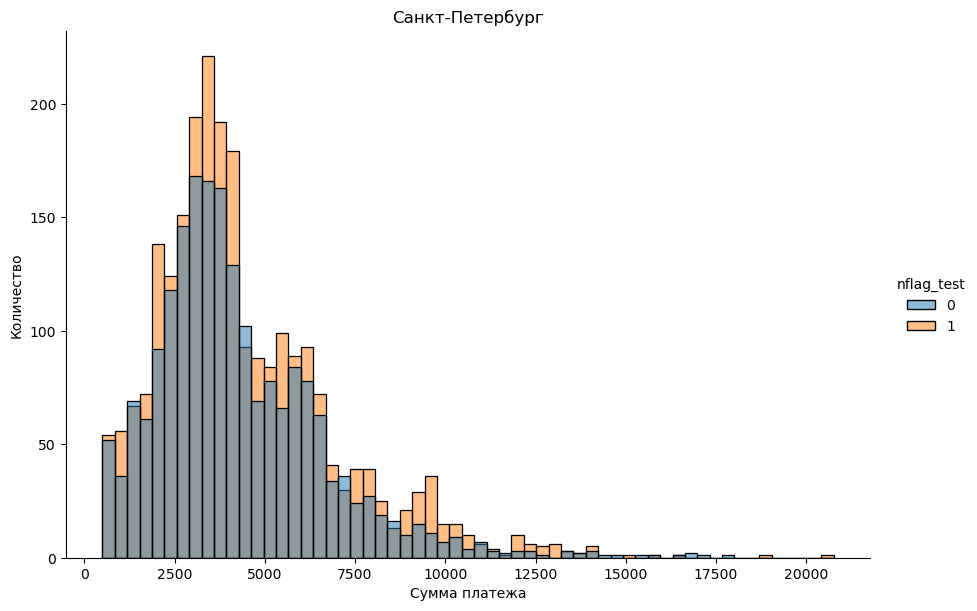

city Санкт-Петербург
T-критерий сравнения конверсий -9.352468686561785
P-value сравнения конверсий 1.065825659919673e-20
Конверсии равны False
Т-критерий сравнения средних -8.759635784179547
Р-value сравнений средних 2.3198088937974163e-18
Средние равны False
U-критерий сравнения средних 8809444.5
P-value U теста 2.0392184217953754e-20
Распределения равны False



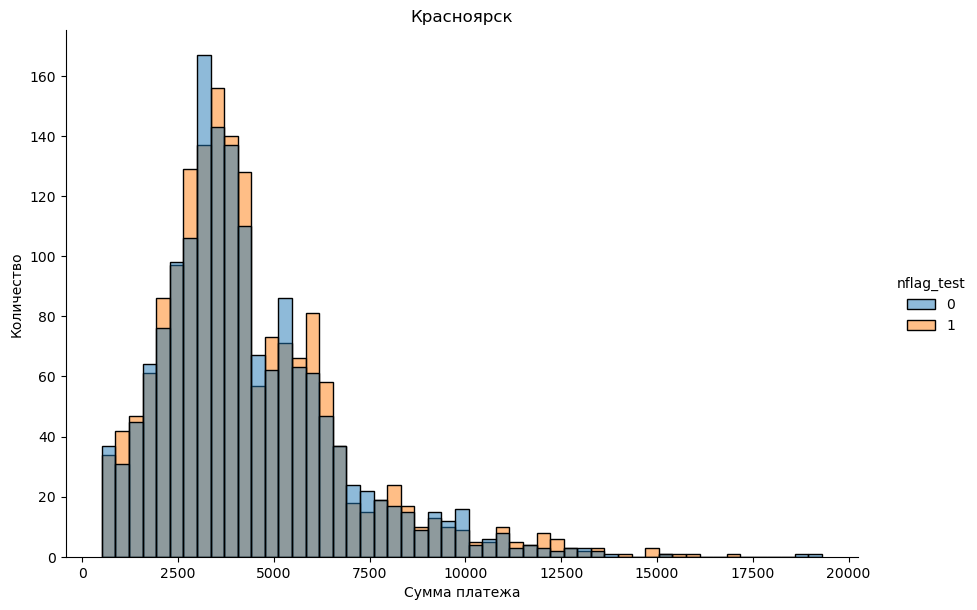

city Красноярск
T-критерий сравнения конверсий 0.27863631219717744
P-value сравнения конверсий 0.7805336501430107
Конверсии равны True
Т-критерий сравнения средних -0.12000608689929208
Р-value сравнений средних 0.9044823881233125
Средние равны True
U-критерий сравнения средних 4413418.0
P-value U теста 0.8770469886251647
Распределения равны True



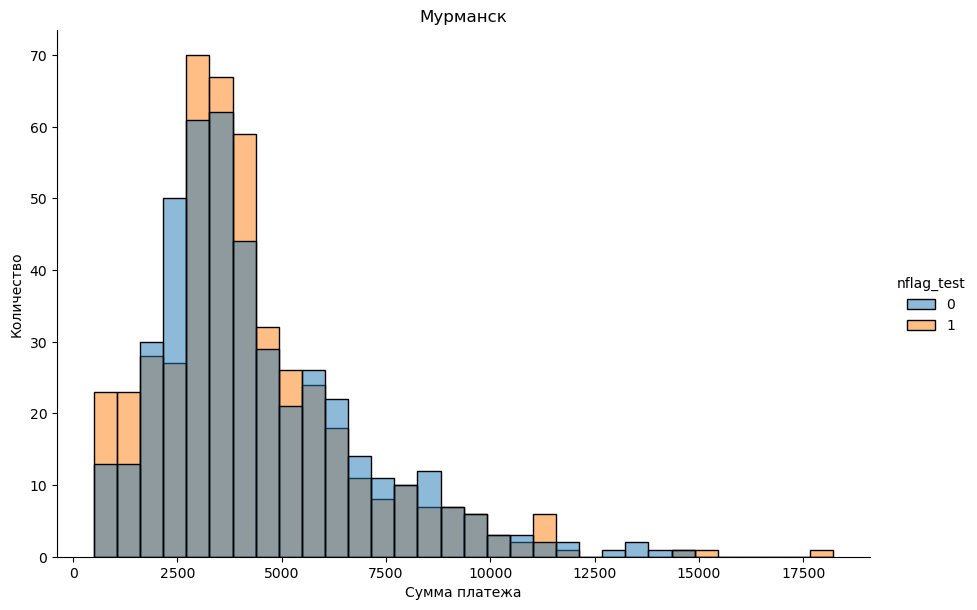

city Мурманск
T-критерий сравнения конверсий -0.8460108060373052
P-value сравнения конверсий 0.3976422846466432
Конверсии равны True
Т-критерий сравнения средних -0.06902498862889384
Р-value сравнений средних 0.9449762446327565
Средние равны True
U-критерий сравнения средних 554067.5
P-value U теста 0.5434251528583327
Распределения равны True



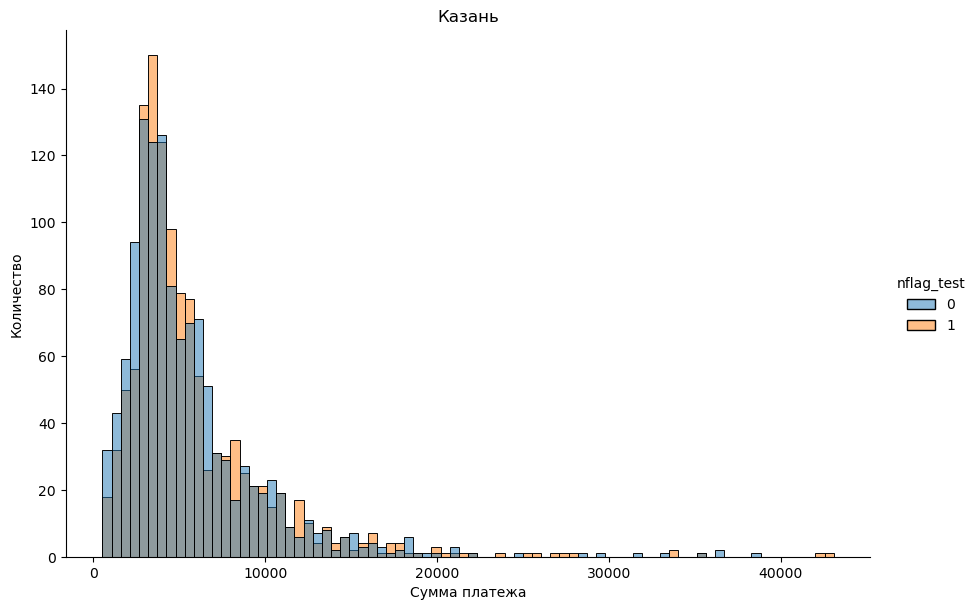

city Казань
T-критерий сравнения конверсий -0.27304492857426443
P-value сравнения конверсий 0.784829789025573
Конверсии равны True
Т-критерий сравнения средних -1.0655273408818378
Р-value сравнений средних 0.286688049247618
Средние равны True
U-критерий сравнения средних 3178575.0
P-value U теста 0.37726004167062477
Распределения равны True



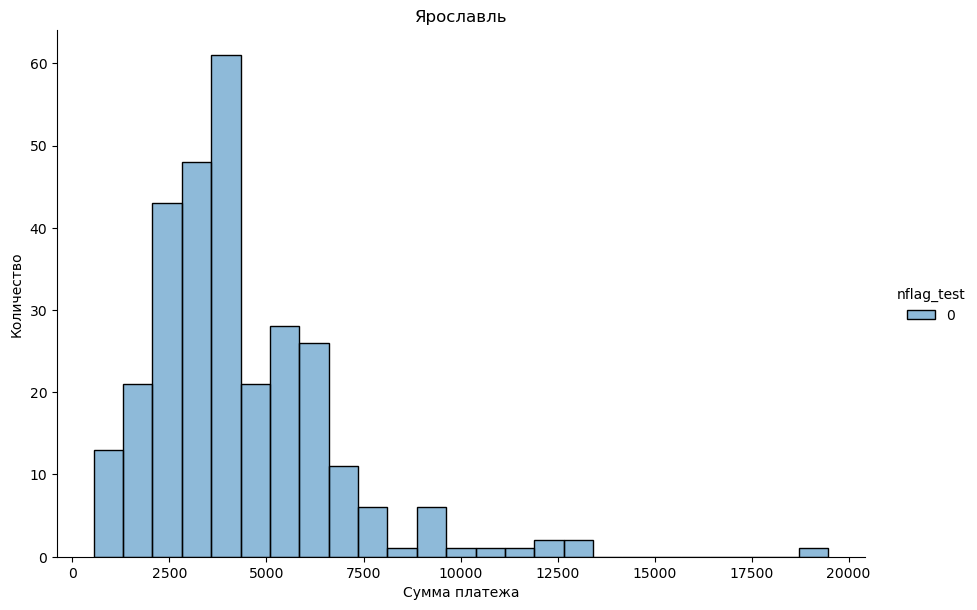

city Ярославль
T-критерий сравнения конверсий 26.272725890733632
P-value сравнения конверсий 4.052580395544189e-118
Конверсии равны False
Т-критерий сравнения средних 20.320571854948493
Р-value сравнений средних 4.9011004367076225e-78
Средние равны False
U-критерий сравнения средних 228927.0
P-value U теста 7.664284737629746e-91
Распределения равны False



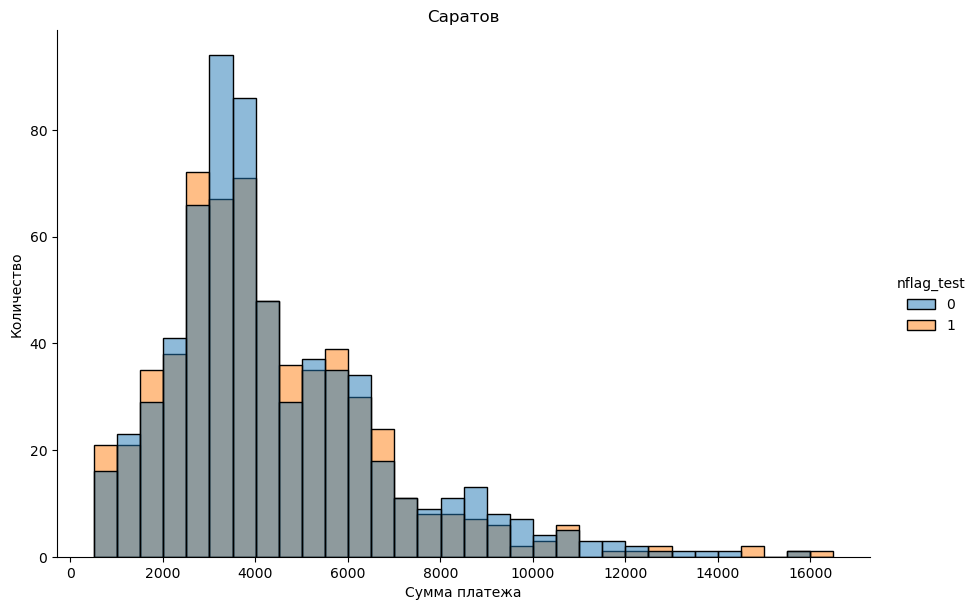

city Саратов
T-критерий сравнения конверсий -0.6507850002388367
P-value сравнения конверсий 0.5152558091282403
Конверсии равны True
Т-критерий сравнения средних 0.10516947629572568
Р-value сравнений средних 0.9162512798549167
Средние равны True
U-критерий сравнения средних 557976.5
P-value U теста 0.7833257779753139
Распределения равны True



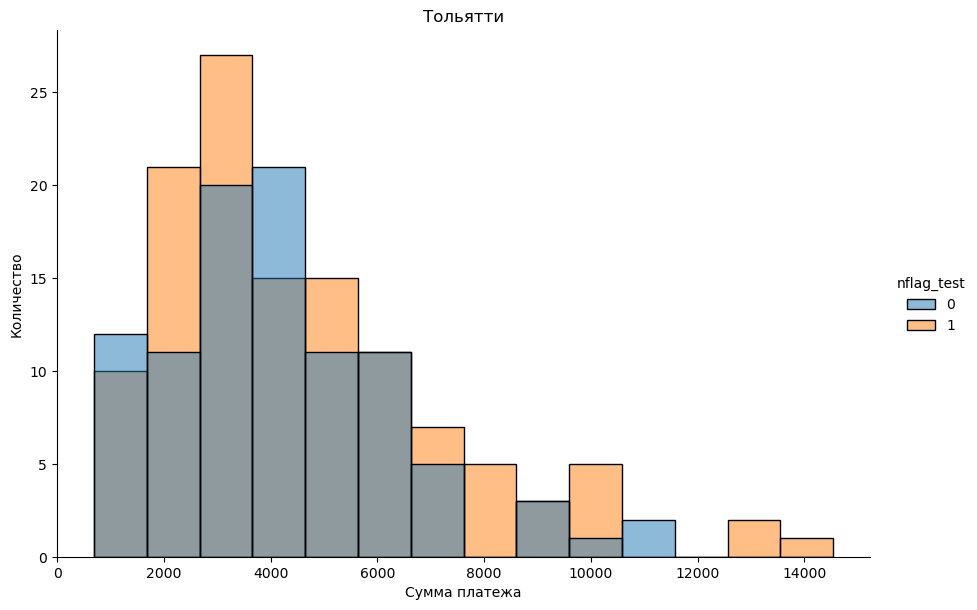

city Тольятти
T-критерий сравнения конверсий -1.185144360467606
P-value сравнения конверсий 0.2367531179978554
Конверсии равны True
Т-критерий сравнения средних -1.5045563456740754
Р-value сравнений средних 0.1333273246710206
Средние равны True
U-критерий сравнения средних 14709.5
P-value U теста 0.22134177144014489
Распределения равны True



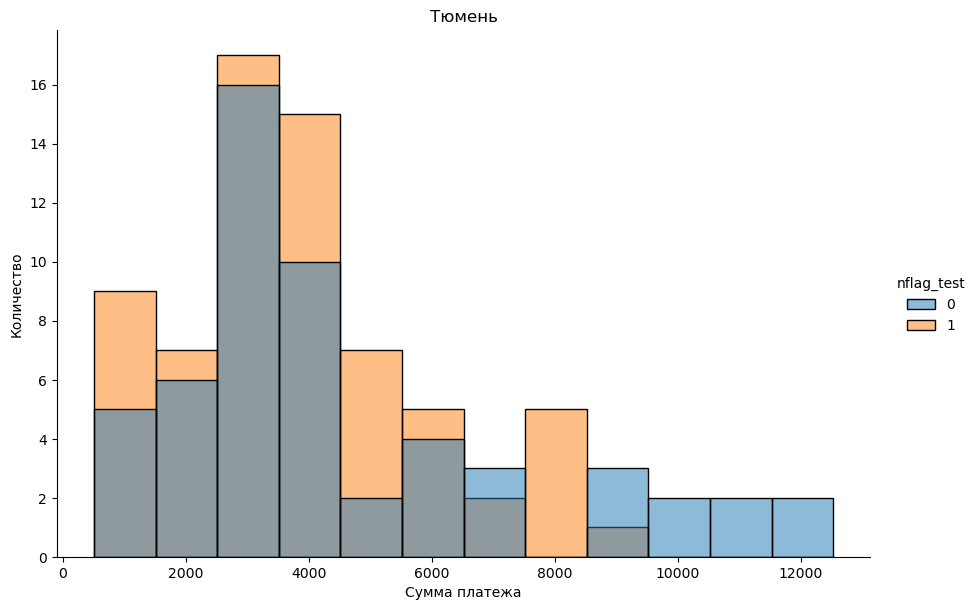

city Тюмень
T-критерий сравнения конверсий -2.4598250966325907
P-value сравнения конверсий 0.01451825932213329
Конверсии равны False
Т-критерий сравнения средних -0.9264590634677944
Р-value сравнений средних 0.3550227648604757
Средние равны True
U-критерий сравнения средних 8239.0
P-value U теста 0.038066216007540725
Распределения равны False



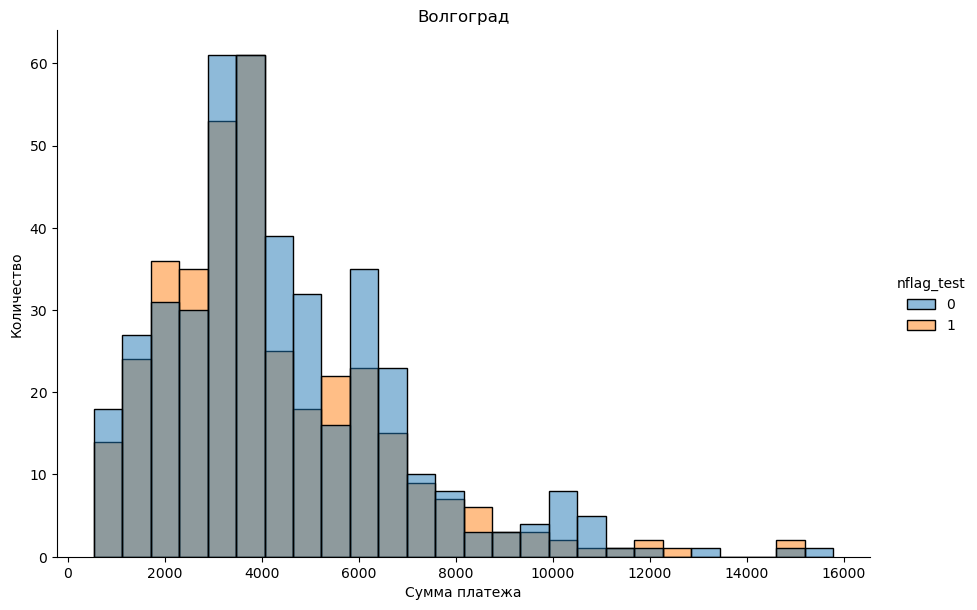

city Волгоград
T-критерий сравнения конверсий 1.6222173039489063
P-value сравнения конверсий 0.10498894497258296
Конверсии равны True
Т-критерий сравнения средних 2.0892718943323443
Р-value сравнений средних 0.03686899928098654
Средние равны False
U-критерий сравнения средних 245743.0
P-value U теста 0.03323940159324537
Распределения равны False



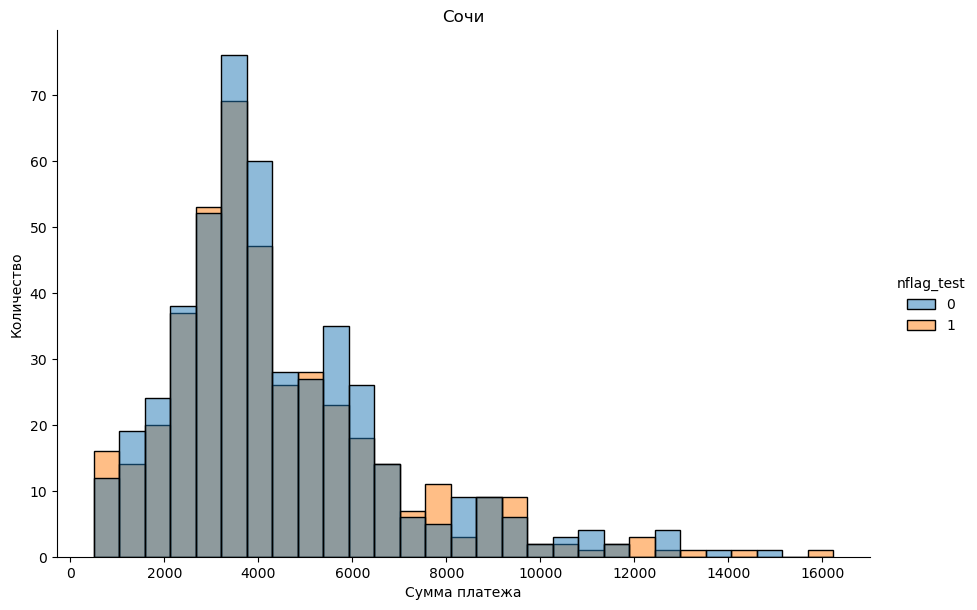

city Сочи
T-критерий сравнения конверсий 1.9849560691617736
P-value сравнения конверсий 0.047319885252583245
Конверсии равны False
Т-критерий сравнения средних 1.5432162776667724
Р-value сравнений средних 0.12297605685687812
Средние равны True
U-критерий сравнения средних 337587.5
P-value U теста 0.05698257474271896
Распределения равны True



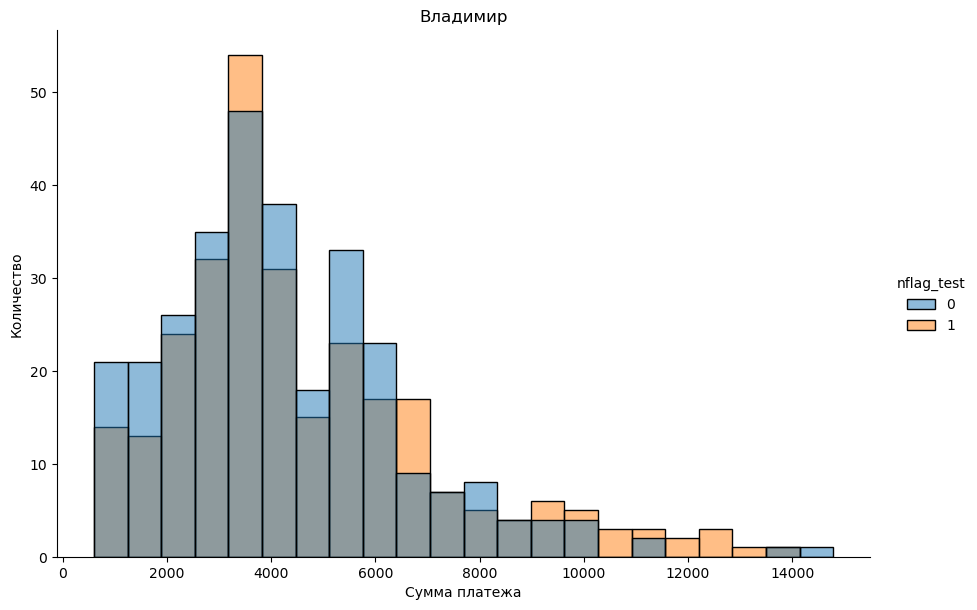

city Владимир
T-критерий сравнения конверсий -1.724937016780416
P-value сравнения конверсий 0.08481593543159477
Конверсии равны True
Т-критерий сравнения средних -2.5769554932923184
Р-value сравнений средних 0.010095112170351712
Средние равны False
U-критерий сравнения средних 143847.0
P-value U теста 0.03166761411886426
Распределения равны False



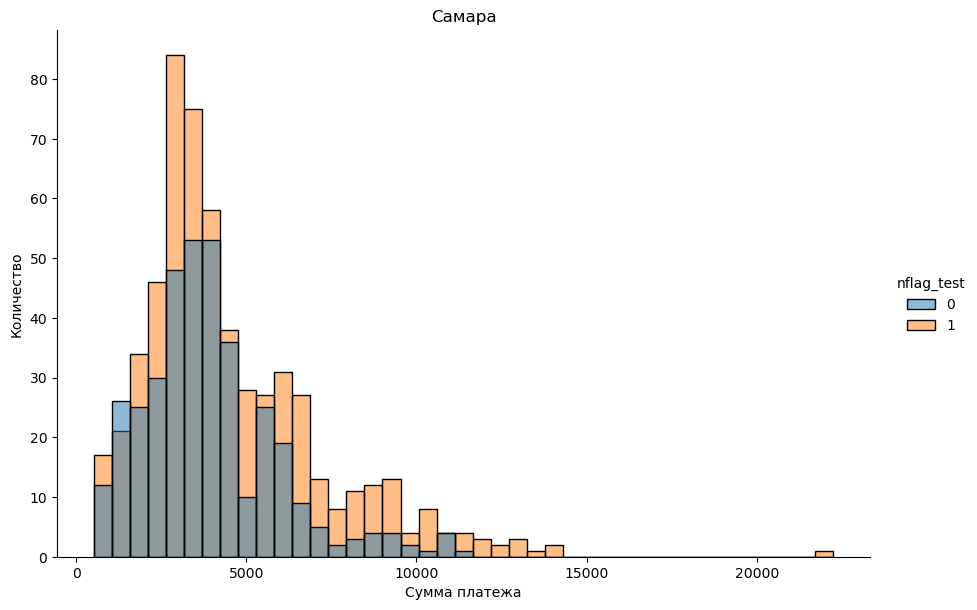

city Самара
T-критерий сравнения конверсий -11.846151689470245
P-value сравнения конверсий 3.981449742682522e-31
Конверсии равны False
Т-критерий сравнения средних -11.54083248253458
Р-value сравнений средних 1.1014020778472052e-29
Средние равны False
U-критерий сравнения средних 233516.5
P-value U теста 4.325201867794148e-30
Распределения равны False



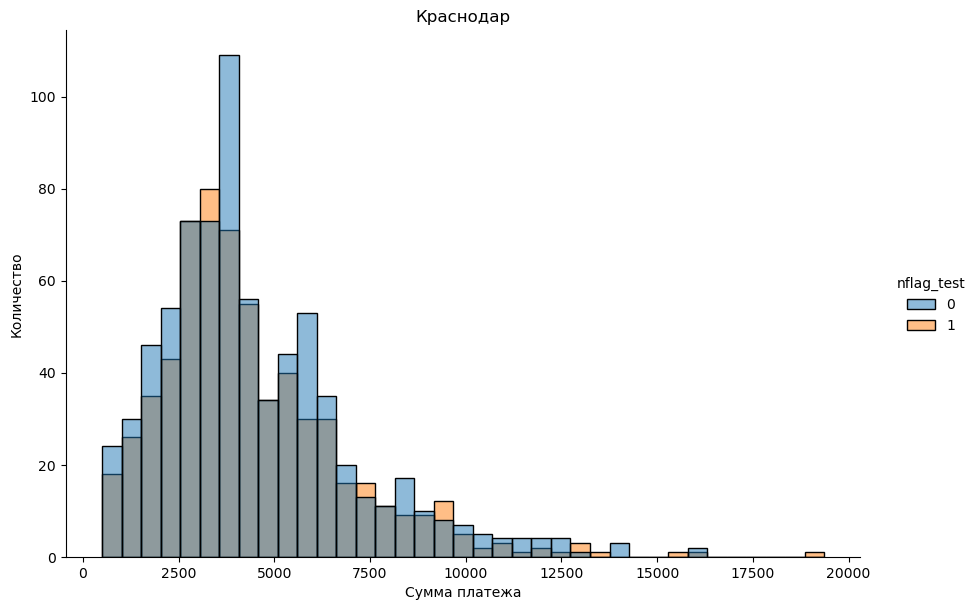

city Краснодар
T-критерий сравнения конверсий 1.8789539353324407
P-value сравнения конверсий 0.060385275678499745
Конверсии равны True
Т-критерий сравнения средних 1.718766529966594
Р-value сравнений средних 0.085800112916198
Средние равны True
U-критерий сравнения средних 609837.0
P-value U теста 0.05938101983441801
Распределения равны True



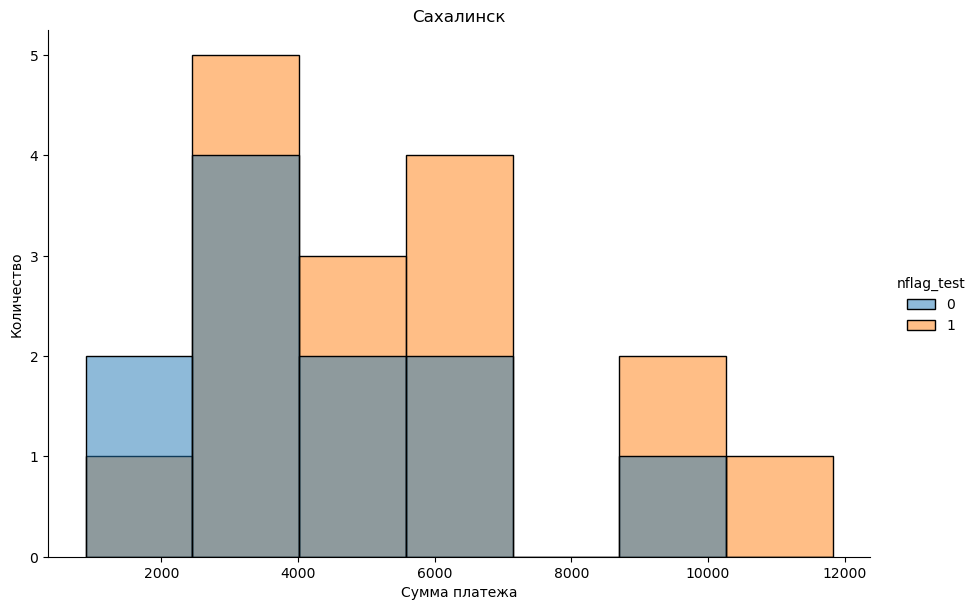

city Сахалинск
T-критерий сравнения конверсий -1.1704284638604743
P-value сравнения конверсий 0.24367247406936435
Конверсии равны True
Т-критерий сравнения средних -1.6270604929283117
Р-value сравнений средних 0.10580921254927302
Средние равны True
U-критерий сравнения средних 2690.5
P-value U теста 0.19868569514015844
Распределения равны True



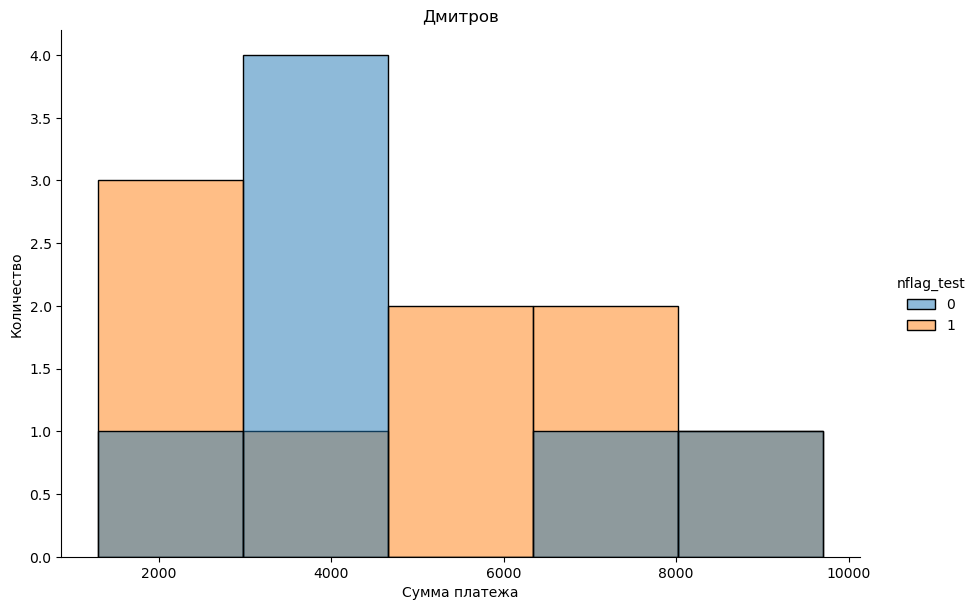

city Дмитров
T-критерий сравнения конверсий -0.3285782051097397
P-value сравнения конверсий 0.7429421277261776
Конверсии равны True
Т-критерий сравнения средних -0.3310524347645207
Р-value сравнений средних 0.7410763125801646
Средние равны True
U-критерий сравнения средних 2722.0
P-value U теста 0.7422551789442879
Распределения равны True



city,T-критерий сравнения конверсий,P-value сравнения конверсий,Конверсии равны,Т-критерий сравнения средних,Р-value сравнений средних,Средние равны,U-критерий сравнения средних,P-value U теста,Распределения равны
Москва,-6.190,0.000,False,-7.677,0.000,False,17582441.500,0.000,False
Санкт-Петербург,-9.352,0.000,False,-8.760,0.000,False,8809444.500,0.000,False
Красноярск,0.279,0.781,True,-0.120,0.904,True,4413418.000,0.877,True
Мурманск,-0.846,0.398,True,-0.069,0.945,True,554067.500,0.543,True
Казань,-0.273,0.785,True,-1.066,0.287,True,3178575.000,0.377,True
Ярославль,26.273,0.000,False,20.321,0.000,False,228927.000,0.000,False
Саратов,-0.651,0.515,True,0.105,0.916,True,557976.500,0.783,True
Тольятти,-1.185,0.237,True,-1.505,0.133,True,14709.500,0.221,True
Тюмень,-2.460,0.015,False,-0.926,0.355,True,8239.000,0.038,False
Волгоград,1.622,0.105,True,2.089,0.037,False,245743.000,0.033,False


In [27]:
df_ab_segm = ttest_mw_func(df_clean, 1)
df_ab_segm

## Если смотреть сегментированные результаты АБ теста:

Города с конверсией тестовой группы выше: Москва, Санкт-Петербург, Тюмень, Самара.

Города со средним чеком тестовой группы выше: Москва, Санкт-Петербург, Владимир, Самара.

Конверсия контрольной группы выше в Сочи.

Средний чек контрольной группы выше в Волгограде.

В Ярославле нет покупок от тестовой группы, хотя обе наполненны. Вероятно ошибка данных.

В Тюмени Т-критерий показывает что средние чеки равны, а критерий Манна-Уитни показывает разницу. Связано с тем что у контрольной группы в распределении платежей большой хвост справа. Средние можно считать равными.


### Создаём функцию для подготовки отчёта по АБ тесту.

In [28]:
def test_function(df,
                  test_column_name = 'amt_payment', segm_column_name = 'id_trading_point',
                  group_column_name = 'nflag_test',
                 alpha = .05):
    
    
    
    test_list = []
    for i in df[segm_column_name].unique():
    
        test_dict = {}

        s_t, p_t = stat.ttest_ind(df[test_column_name][(df[group_column_name]==1) & (df[segm_column_name]==i)],
                              df[test_column_name][(df[group_column_name]==0) & (df[segm_column_name]==i)])
        
        test_dict[segm_column_name] = i
        test_dict['count_all'] = df[group_column_name][df[segm_column_name]==i].count()
        test_dict['count_test'] = df[group_column_name][df[segm_column_name]==i].sum()    
        test_dict['count_control'] = test_dict['count_all'] - test_dict['count_test']
        
        test_dict['percent_count'] = test_dict['count_all'] / len(df)
        
        test_dict['avg_payment_test'] = df[test_column_name][(df[group_column_name]==1) & (df[segm_column_name]==i)].mean()
        test_dict['avg_payment_control'] = df[test_column_name][(df[group_column_name]==0) & (df[segm_column_name]==i)].mean()
        test_dict['diff'] = test_dict['avg_payment_test'] - test_dict['avg_payment_control']
        
        test_dict['sigma_test'] =  df[test_column_name][(df[group_column_name]==1) & (df[segm_column_name]==i)].std()
        test_dict['sigma_control'] = df[test_column_name][(df[group_column_name]==0) & (df[segm_column_name]==i)].std()
        
        
        test_dict['ttest'] = s_t
        test_dict['p_value_ttest']= p_t
        
        if p_t > alpha:
            test_dict['result'] = 'нейтральный исход'
        else:
            if test_dict['diff'] > 0:
                test_dict['result'] = 'положительный исход'
            else:
                test_dict['result'] = 'отрицательный исход'
                
        test_list.append(test_dict)
       
    return pd.DataFrame(test_list)

In [29]:
df_res = test_function(df_clean)
df_res = region_dict.merge(df_res, on = 'id_trading_point').set_index(['city']).reset_index()
df_res

,city,id_trading_point,count_all,count_test,count_control,percent_count,avg_payment_test,avg_payment_control,diff,sigma_test,sigma_control,ttest,p_value_ttest,result
0,Дмитров,2,149,78,71,0.003211,579.333333,483.450704,95.882629,1860.762430,1654.923182,0.331052,7.410763e-01,нейтральный исход
1,Владимир,11,1117,509,608,0.024071,2547.220039,2108.610197,438.609842,3023.702164,2663.038392,2.576955,1.009511e-02,положительный исход
2,Тюмень,19,276,130,146,0.005948,2043.823077,1743.376712,300.446365,2442.266788,2891.333359,0.926459,3.550228e-01,нейтральный исход
3,Самара,33,490,232,258,0.010559,4598.219828,2311.387597,2286.832231,2931.234926,2371.771296,9.532838,7.222519e-20,положительный исход
4,Самара,34,478,225,253,0.010301,3104.506667,1752.608696,1351.897971,2956.826915,2529.700798,5.386265,1.132779e-07,положительный исход
5,Самара,35,408,214,194,0.008792,2762.224299,1508.835052,1253.389248,2977.083547,2184.808094,4.806666,2.164676e-06,положительный исход
6,Самара,36,272,131,141,0.005862,1987.328244,860.418440,1126.909805,2718.502663,1840.826639,4.027951,7.318758e-05,положительный исход
7,Ярославль,46,1086,557,529,0.023403,0.000000,2359.013233,-2359.013233,0.000000,2739.887003,-20.320572,4.901100e-78,отрицательный исход
8,Мурманск,54,1273,633,640,0.027433,1702.714060,1688.512500,14.201560,2565.132440,2628.012490,0.097556,9.223005e-01,нейтральный исход
9,Мурманск,55,847,422,425,0.018253,2109.106635,2111.272941,-2.166306,2790.993385,2804.223188,-0.011268,9.910125e-01,нейтральный исход


### Экспортируем отчёт для дальнейшей работы с ним в Excel

In [30]:
with ExcelWriter('output.xlsx', engine='openpyxl') as writer:
    for tag, group in df_res.groupby('result'):
        group.drop(columns='result', inplace=True)
        if not group.empty:
            group.to_excel(writer, sheet_name=tag, index=False)